Logistic Classification
=======================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour details the logistic classification method (for 2 classes and
multi-classes).


_Warning:_ Logisitic classification is actually called ["logistic
regression"](https://en.wikipedia.org/wiki/Logistic_regression) in the literature, but it is in fact a classification method.


We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from [LibSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).

_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
[Scikit-Learn](http://scikit-learn.org/)

In [1]:
source("nt_toolbox/general.R")
library(plot3D)
library(pracma)


Attaching package: ‘pracma’

The following object is masked _by_ ‘.GlobalEnv’:

    circshift



We define a few helpers.

In [2]:
Xm = function(X){as.matrix(X - rep(colMeans(X), rep.int(nrow(X), ncol(X))))}
Cov = function(X){data.matrix(1. / (n - 1) * t(Xm(X)) %*% Xm(X))}

Two Classes Logistic Classification
-----------------------------------
Logistic classification is, with [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine), the baseline
method to perform classification. Its main advantage over SVM is that is
is a smooth minimization problem, and that it also output class
probabity, offering a probabilistic interpretation of the classification.


To understand the behavior of the method, we generate synthetic data
distributed according to a mixture of Gaussian with an overlap governed by an offset $\omega$.
 Here classes indexes are set to $y_i \in
\{-1,1\}$ to simplify the equations.

In [3]:
n = 1000 # number of sample
p = 2 # dimensionality
omega = 1.5 * 5
X = rbind(randn(n/2,2), randn(n/2,2) + rep(1, n/2) * omega)
y = c(rep(1, n/2), rep(-1, n/2))

Plot the classes.

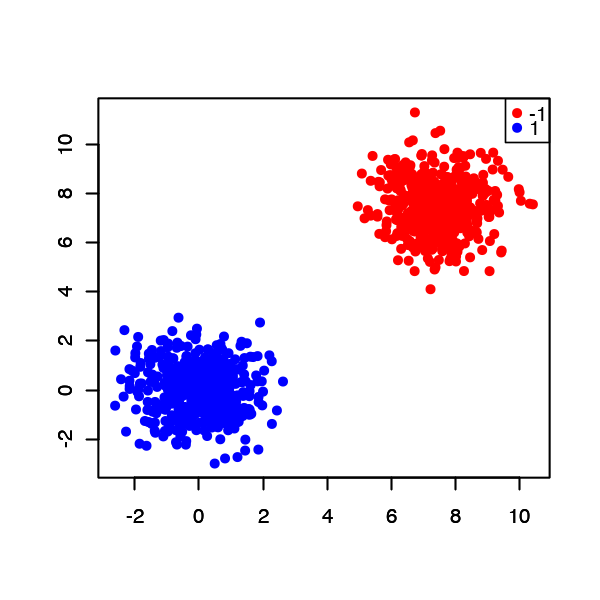

In [4]:
options(repr.plot.width=5, repr.plot.height=5)

for (i in c(-1, 1))
{
    I = (y==i)
    plot(X[I,1], X[I,2], col=(i + 3), xlim=c(min(X[,1]), max(X[,1])),  
         ylim=c(min(X[,2]), max(X[,2])), xlab="", ylab="", pch=16)
    par(new=TRUE)
}

cols = c(2,4)
legend("topright", legend=c(-1, 1), col=cols, pch=16)

Logistic classification minimize a logistic loss in place of the usual
$\ell^2$ loss for regression
  $$ \umin{w} E(w) \eqdef \frac{1}{n} \sum_{i=1}^n L(\dotp{x_i}{w},y_i)  $$
where the logistic loss reads
  $$ L( s,y ) \eqdef \log( 1+\exp(-sy) ) $$
This corresponds to a smooth convex minimization. If $X$ is injective,
this is also strictly convex, hence it has a single global minimum.


Compare the binary (ideal) 0-1 loss, the logistic loss and the
<https://en.wikipedia.org/wiki/Hinge_loss hinge loss>
(the one used for SVM).

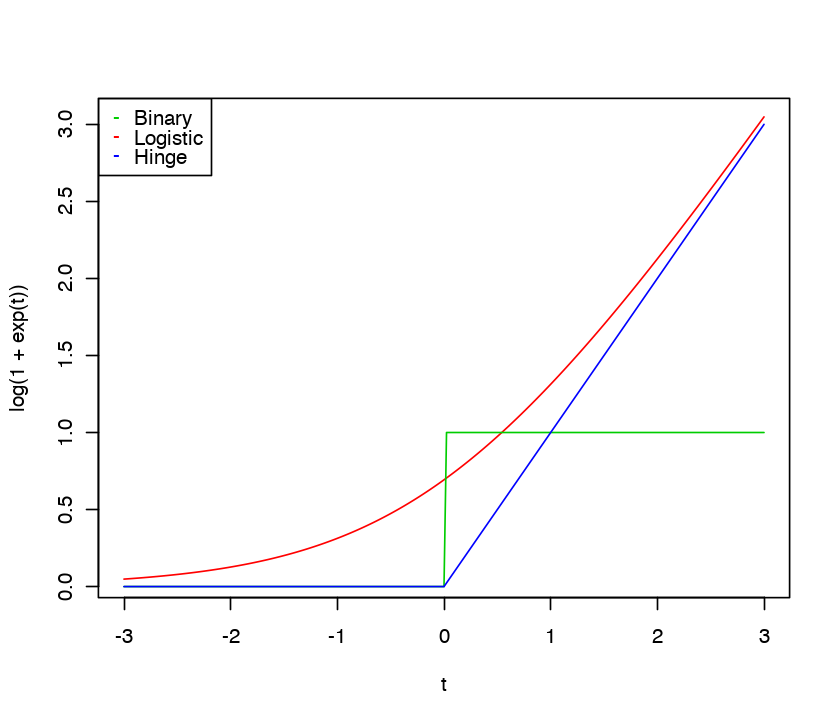

In [5]:
options(repr.plot.width=7, repr.plot.height=6)
t = seq(-3, 3, length=255)
plot(t, log(1 + exp(t)), type="l", col=2)
#plot(t, t > 0)
lines(t, t > 0, col=3)
lines(t, pmax(t, 0), col=4)
legend("topleft", legend=c('Binary', 'Logistic', 'Hinge'), col=c(3,2,4), pch="-")

This can be interpreted as a <https://en.wikipedia.org/wiki/Maximum_likelihood_estimation maximum likelihood estimator> when one
models the probability of  belonging to the two classes for sample $x_i$ as
  $$ h(x_i) \eqdef (\th(x_i),1-\th(x_i)) \qwhereq
          \th(s) \eqdef \frac{e^{s}}{1+e^s} = (1+e^{-s})^{-1}  $$


Re-writting the energy to minimize
  $$ E(w) = \Ll(X w,y) \qwhereq \Ll(s,y)= \frac{1}{n}  \sum_i L(s_i,y_i), $$
its gradient reads
  $$ \nabla E(w) = X^\top \nabla \Ll(X w,y)
      \qwhereq
      \nabla \Ll(s,y) = \frac{y}{n} \odot \th(-y \odot s),   $$
where $\odot$ is the pointwise multiplication operator, i.e. |.*| in
Matlab.


Define the energies.

In [6]:
L = function(s,y){1/n * sum( log(1 + exp(-s * y)))}
E = function(w,X,y){L(X %*% w, y)}

Define their gradients.

In [7]:
theta = function(v){1 / (1 + exp(-v))}
nablaL = function(s, r){ - 1/n * y * theta(-s * y)}
nablaE = function(w,X,y){t(X) %*% nablaL(X %*% w,y)}

_Important:_ in order to improve performance, it is important (especially
in low dimension $p$) to add a constant bias term $w_{p+1} \in \RR$, and replace $\dotp{x_i}{w}$
by $ \dotp{x_i}{w} + w_{p+1} $.  This is equivalently achieved by
adding an extra $(p+1)^{\text{th}}$ dimension equal to 1 to each
$x_i$, which we do using a convenient macro.

In [8]:
AddBias = function(X){cbind(X, rep(1, dim(X)[1]))}

With this added bias term, once $w_{\ell=0} \in \RR^{p+1}$ initialized
(for instance at $0_{p+1}$),

In [9]:
w = rep(0, p + 1)
dim(w) = c(p+1, 1)

one step of gradient descent reads
 $$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E(w_\ell). $$

In [10]:
tau = .8 # here we are using a fixed tau
w = w - tau * nablaE(w, AddBias(X), y)

__Exercise 1__

Implement a gradient descent
$$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E(w_\ell). $$
Monitor the energy decay.
Test different step size, and compare with the theory (in particular
plot in log domain to illustrate the linear rate).

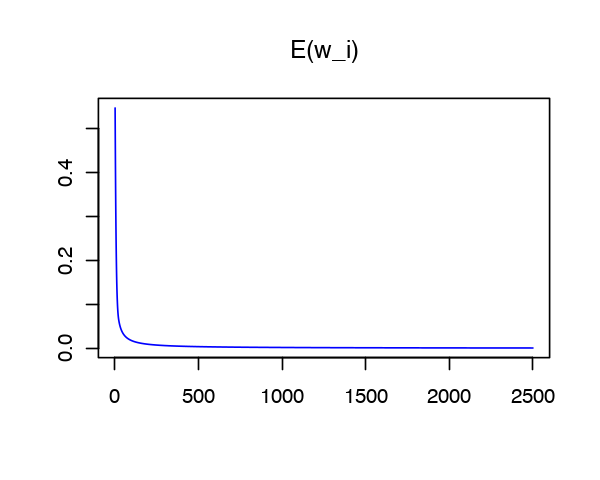

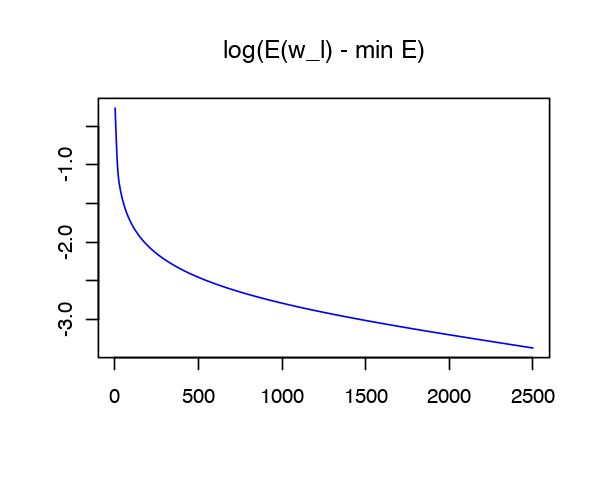

In [11]:
options(repr.plot.width=5, repr.plot.height=4)
niter = 5000
w = rep(0, p + 1)
Elist = c()

for (i in 1:niter)
{
    w = w - tau * nablaE(w, AddBias(X), y)
    Elist = c(Elist, E(w,AddBias(X),y))
}

ndisp = niter/2
plot(1:ndisp, Elist[1:ndisp], type='l', col=4, xlab="", ylab="",  main="E(w_i)")
plot(1:ndisp, log(Elist[1:ndisp]-min(Elist), 10), type='l', col=4,
     xlab="", ylab="",  main="log(E(w_l) - min E)")

Generate a 2D grid of points.

In [12]:
q = 201
tx = seq(min(X[,1]), max(X[,1]), length=q)
ty = seq(min(X[,2]),max(X[,2]), length=q)
B = as.vector(meshgrid(ty, tx)$X)
A = as.vector(meshgrid(ty, tx)$Y)
G = matrix(c(A, B), nrow=length(A), ncol=2)

Evaluate class probability associated to weight vectors on this grid.

In [13]:
Theta = theta(AddBias(G) %*% w)
dim(Theta) = c(q, q)

Display the data overlaid on top of the
classification probability, this highlight the
separating hyperplane $ \enscond{x}{\dotp{w}{x}=0} $.

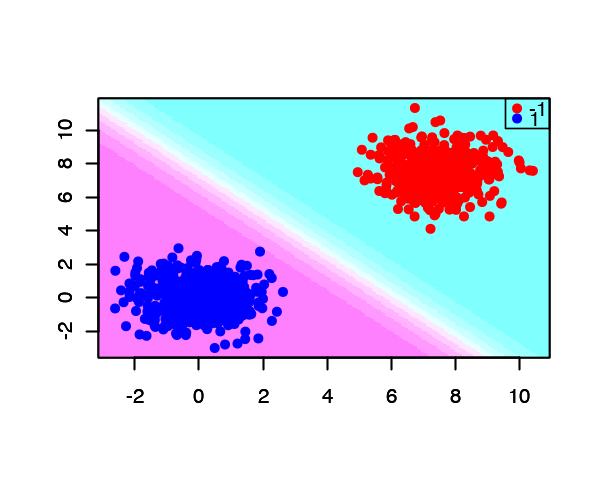

In [14]:
image(tx,ty, Theta, xlab="", ylab="", col=cm.colors(10), xaxt="n", yaxt="n")
par(new=TRUE)
for (i in c(-1, 1))
{
    I = (y==i)
    plot(X[I,1], X[I,2], col=(i + 3), xlim=c(min(X[,1]), max(X[,1])),  
         ylim=c(min(X[,2]), max(X[,2])), xlab="", ylab="", pch=16)
    par(new=TRUE)
}

cols = c(2,4)
legend("topright", legend=c(-1, 1), col=cols, pch=16)

__Exercise 2__

Test the influence of the separation offset $\omega$ on the result.

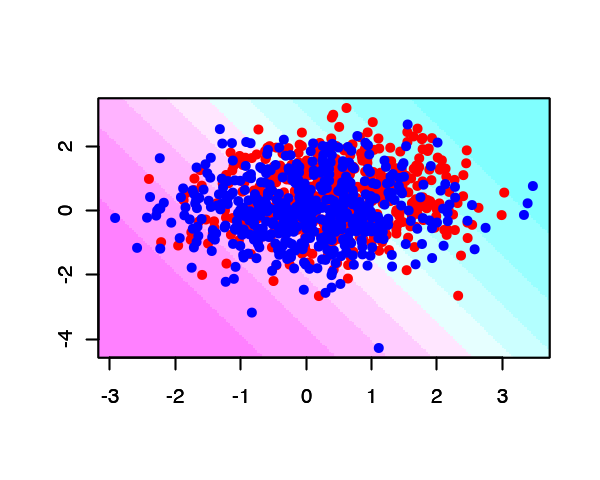

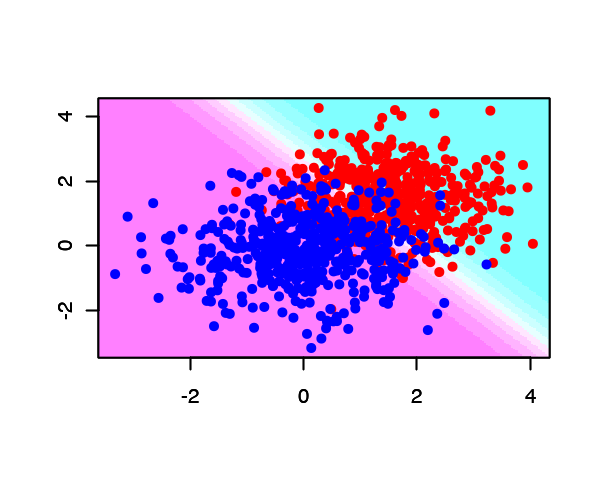

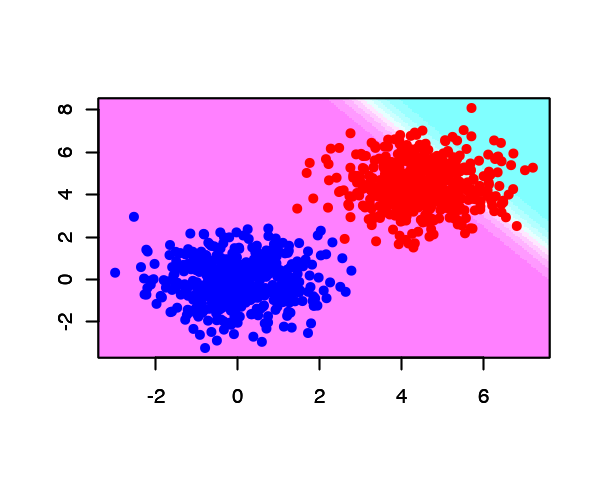

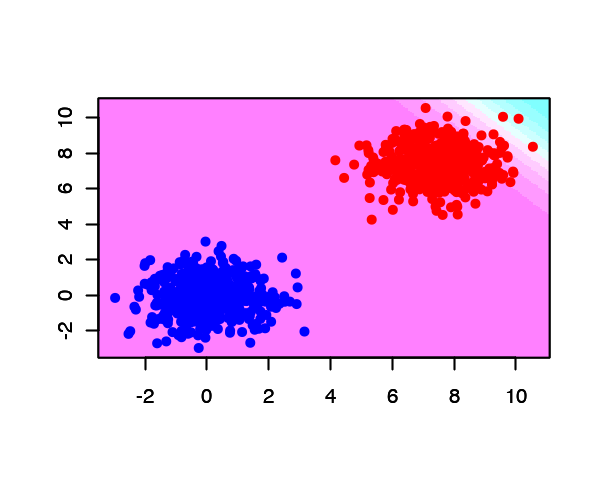

In [15]:
a = 5
b = 3.5
tx = seq(-a, a, length=q)
ty = seq(-b, b, length=q)
B = as.vector(meshgrid(ty, tx)$X)
A = as.vector(meshgrid(ty, tx)$Y)
G = matrix(c(A, B), nrow=length(A), ncol=2)
offs = c(0.3, 1, 3, 5)
niter = 10000

for (io in 1:length(offs))
{
    # generate data
    omega = offs[io] * 1.5
    X = rbind(randn(n/2,2), randn(n/2,2) + rep(1, n/2) * omega)
    y = c(rep(1, n/2), rep(-1, n/2))
    # run gradient descent
    w = rep(0, p + 1)
    for (i in 1:niter)
    {
    w = w - tau * nablaE(w, AddBias(X), y)
    }

    # display
    Theta = theta(AddBias(G) %*% w)
    dim(Theta) = c(q, q)

    image(tx,ty, Theta, xlab="", ylab="", col=cm.colors(10), xaxt="n", yaxt="n")
    par(new=TRUE)
    for (i in c(-1, 1))
    {
        I = (y==i)
        plot(X[I,1], X[I,2], col=(i + 3), xlim=c(min(X[,1]), max(X[,1])),  
         ylim=c(min(X[,2]), max(X[,2])), xlab="", ylab="", pch=16)
        par(new=TRUE)
    }
    par(new=FALSE)
}

In [16]:
%% Insert your code here.

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected SPECIAL
1: %%
    ^


__Exercise 3__

Test logistic classification on a real life dataset. You can look at the Numerical Tour on stochastic gradient descent
for an example. Split the data in training and testing to evaluate the
classification performance, and check the impact of regularization.

In [ ]:
exo3()

In [ ]:
%% Insert your code here.

Kernelized Logistic Classification
----------------------------------
Logistic classification tries to separate the classes using
a linear separating hyperplane $ \enscond{x}{\dotp{w}{x}=0}. $


In order to generate a non-linear descision boundary, one can replace the
parametric linear model by a non-linear [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) model, thanks to
kernelization. It is non-parametric in the sense that the number of
parameter grows with the number $n$ of sample (while for the basic
method, the number of parameter is $p$. This allows in particular to
generate decision boundary of arbitrary complexity.


The downside is that the numerical complexity of the method grows
(at least) quadratically with $n$.


The good news however is that thanks to the theory of
 [reproducing kernel Hilbert spaces](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
(RKHS), one can still compute this non-linear decision
function using (almost) the same numerical algorithm.


Given a kernel $ \kappa(x,z) \in \RR $ defined for $(x,z) \in \RR^p$,
the kernelized method replace the linear decision functional $f(x) =
\dotp{x}{w}$ by a sum of kernel centered on the samples
$$ f_h(x) = \sum_{i=1}^p h_i k(x_i,x) $$
where $h \in \RR^n$ is the unknown vector of weight to find.


When using the linear kernel $\kappa(x,y)=\dotp{x}{y}$, one retrieves
the previously studied linear method.


Macro to compute pairwise squared Euclidean distance matrix.

In [ ]:
distmat = function(X,Z)
{
    dist1 = diag(X %*% t(X))
    dist2 = diag(Z %*% t(Z))
    n1 = dim(X)[1]
    n2 = dim(Z)[1]
    out = matrix(0, n1, n2)
    for (i in 1:n1)
    {
        for (j in 1:n2)
        {
            out[i,j] = dist1[i] + dist2[j]
        }
    }
    out = out - 2 * X %*% t(Z)

    return(out)
}

The gaussian kernel is the most well known and used kernel
$$ \kappa(x,y) \eqdef e^{-\frac{\norm{x-y}^2}{2\sigma^2}} . $$
The bandwidth parameter $\si>0$ is crucial and controls the locality of
the model. It is typically tuned through cross validation.

In [ ]:
kappa = function(X,Z,sigma){exp( -distmat(X,Z)/(2*sigma^2))}

We generate synthetic data in 2-D which are not separable by an
hyperplane.

In [ ]:
n = 1000
p = 2
t = 2 * pi * rand(n/2,1)
R = 2.5
r = R * (1 + .2 * rand(n/2,1)) # radius
X1 = cbind(cos(t) * r, sin(t) * r)
X = rbind(randn(n/2, 2), X1)
y = c(rep(1, n/2), rep(-1, n/2))

Display the classes.

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

for (i in c(-1, 1))
{
    I = (y==i)
    plot(X[I,1], X[I,2], col=(i + 3), xlim=c(min(X[,1]), max(X[,1])),  
         ylim=c(min(X[,2]), max(X[,2])), xlab="", ylab="", pch=16)
    par(new=TRUE)
}

cols = c(2,4)
legend("topright", legend=c(-1, 1), col=cols, pch=16)

Once avaluated on grid points, the kernel define a matrix
$$ K = (\kappa(x_i,x_j))_{i,j=1}^n \in \RR^{n \times n}.  $$

In [ ]:
sigma = 1
K = kappa(X, X, sigma)

Valid kernels are those that gives rise to positive symmetric matrices
$K$. The linear and Gaussian kernel are valid kernel functions. Other
popular kernels include the polynomial kernel $ \dotp{x}{y}^a $ for $a
\geq 1$ and the Laplacian kernel $ \exp( -\norm{x-y}^2/\si ) $.


The kernelized Logistic minimization reads
  $$ \umin{h} F(h) \eqdef \Ll(K h,y). $$

In [ ]:
F = function(h,K,y){L(K %*% h, y)}
nablaF = function(h,K,y){t(K) %*% nablaL(K %*% h,y)}

This minimization can be related to an infinite dimensional optimization
problem where one minimizes directly over the function $f$. This
is shown to be equivalent to the above finite-dimenisonal optimization problem
thanks to the theory of RKHS.

__Exercise 4__

Implement a gradient descent to minimize $F(h)$.
Monitor the energy decay.
Test different step size, and compare with the theory.

In [ ]:
options(repr.plot.width=5, repr.plot.height=4)

h = rep(0, n)
Flist = c()
tau = 0.5
niter = 2000

for (i in 1:niter)
{
    h = h - tau * nablaF(h,K,y)
    Flist = c(Flist, F(h,K,y))
}

plot(1:niter, Flist, type="l", col=4, xlab="", ylab="")

Once this optimal $h$ has been found, class probability at a point
$x$ are obtained as
  $$ (\th(f_h(x)), 1-\th(f_h(x)) $$
where $f_h$ has been defined above.


We evaluate this classification probability on a grid.

In [ ]:
q = 201
tmax = 3.5
t = seq(-tmax, tmax, length=q)
B = as.vector(meshgrid(t)$X)
A = as.vector(meshgrid(t)$Y)
G = matrix(c(A, B), nrow=length(A), ncol=2)
Theta = theta(kappa(G,X,sigma) %*% h)
dim(Theta) = c(q, q)

Display the classification probability.

In [ ]:
image(t,t, Theta, xlab="", ylab="", col=cm.colors(10), xaxt="n", yaxt="n")
par(new=TRUE)
for (i in c(-1, 1))
{
    I = (y==i)
    plot(X[I,1], X[I,2], col=(i + 3), xlim=c(min(X[,1]), max(X[,1])),  
         ylim=c(min(X[,2]), max(X[,2])), xlab="", ylab="", pch=16)
    par(new=TRUE)
}

cols = c(2,4)
legend("topright", legend=c(-1, 1), col=cols, pch=16)

__Exercise 5__

Display evolution of the classification probability with $\sigma$

In [ ]:
sigma_list = c(.1, .5, 1, 4)
niter = 4000

for (is in 1:length(sigma_list))
{
    sigma = sigma_list[is]
    # grad descent
    K = kappa(X,X,sigma)
    Flist = c()
    tau = .5
    if (is == 4)
    {
        tau = .05
    }
    h = rep(0, n)

    for (i in 1:niter)
    {
        h = h - tau * nablaF(h,K,y)
        Flist = c(Flist, F(h,K,y))
    }

    # evaluate on a grid
    Theta = theta(kappa(G,X,sigma) %*% h)
    dim(Theta) = c(q, q)
    # Display the classification probability.
    image(t,t, Theta, xlab="", ylab="", col=cm.colors(10), xaxt="n", yaxt="n")
    par(new=TRUE)
    for (i in c(-1, 1))
    {
        I = (y==i)
        plot(X[I,1], X[I,2], col=(i + 3), xlim=c(min(X[,1]), max(X[,1])),  
             ylim=c(min(X[,2]), max(X[,2])), xlab="", ylab="", pch=16, main=paste("sigma =", sigma))
        par(new=TRUE)
    }
    par(new=FALSE)

}

In [ ]:
%% Insert your code here.

__Exercise 6__

Separate the dataset into a training set and a testing set. Evaluate the classification performance
for varying $\si$. Try to introduce regularization and minmize
$$ \umin{h} F(h) \eqdef \Ll(K h,y) + \la R(h) $$
where for instance $R=\norm{\cdot}_2^2$ or  $R=\norm{\cdot}_1$.

In [ ]:
exo6()

In [ ]:
%% Insert your code here.

Multi-Classes Logistic Classification
-------------------------------------
The logistic classification method is extended to an arbitrary number
$k$ of classes by considering a familly of weight vectors $ w_\ell
$, which are conveniently stored as columns of matrix $W \in \RR^{p \times k}$.


This allows to model probabilitically the belonging of a point $x \in \RR^p $ to a
the classes using an exponential model
  $$ h(x) = \pa{ \frac{ e^{-\dotp{x}{w_\ell}} }{ \sum_m e^{-\dotp{x}{w_m}} } }_\ell $$
This vector $h(x) \in [0,1]^k $ describes the probability of $x$
belonging to the different classes, and $ \sum_\ell h(x)_\ell = 1 $.


The computation of $w$ is obtained by solving a maximum likelihood
estimator
   $$ \umax{w \in \RR^k} \frac{1}{n} \sum_{i=1}^n \log( h(x_i)_{y_i} ) $$
where we recall that $y_i \in \{1,\ldots,k\}$ is the class index of
point $x_i$.


This is conveniently rewritten as
  $$ \umin{w} \sum_i \text{LSE}( XW )_i - \dotp{XW}{D} $$
where $D \in \{0,1\}^{n \times k}$ is the binary class index matrices
  $$  D_{i,\ell} = \choice{
          1 \qifq y_i=\ell, \\
          0 \quad \text{otherwise}.
      }
   $$
and LSE is the log-sum-exp operator
  $$ \text{LSE}(S) = \log\pa{ \sum_\ell \exp(S_{i,\ell}) } \in \RR^n. $$

In [57]:
LSE0 = function(S){log(apply(exp(S), 1, sum))}

The computation of LSE is
unstable for large value of $S_{i,\ell}$ (numerical overflow, producing NaN), but this can be
fixed by substracting the largest element in each row,
since $ \text{LSE}(S+a)=\text{LSE}(S)+a $ if $a$ is constant along rows. This is
the [celebrated LSE trick](https://en.wikipedia.org/wiki/LogSumExp).

In [105]:
max2 = function(S){apply(S, 1, max)}
LSE = function(S){LSE0(S - max2(S)) + max2(S)}

The gradient of the LSE operator is the
<https://en.wikipedia.org/wiki/Softmax_function soft-max operator>
$$  \nabla \text{LSE}(S) = \text{SM}(S) \eqdef
      \pa{
          \frac{
                  e^{S_{i,\ell}}
              }{
                  \sum_m e^{S_{i,m}}
              } }   $$

In [106]:
SM0 = function(S){exp(S) / apply(exp(S), 1, sum)}

Similarely to the LSE, it needs to be stabilized.

In [107]:
SM = function(S){SM0(S-max2(S))}

We load a dataset of $n$ images of size $p = 8 \times 8$, representing digits from 0
to 9 (so there are $k=10$ classes).


Load the dataset and randomly permute it.
Separate the features $X$ from the data $y$ to predict information.

In [108]:
file_name = 'nt_toolbox/data/digits.csv'
A = read.table(file_name, sep=",", head=FALSE)
A = A[sample(dim(A)[1]),]
X = as.matrix(A[,1:(dim(A)[2] - 1)])
y = A[,dim(A)[2]]

$n$ is the number of samples, $p$ is the dimensionality of the features, $k$
the number of classes.

In [109]:
n = dim(X)[1]
p = dim(X)[2]
CL = sort(unique(y)) # list of classes.
k = length(CL)

Display a few samples digits

[1] 0


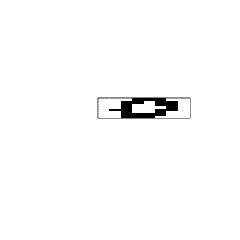

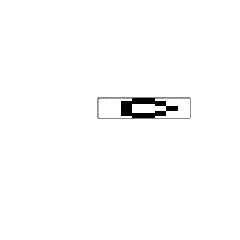

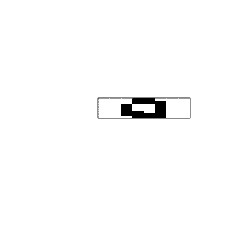

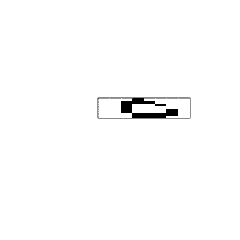

[1] 1


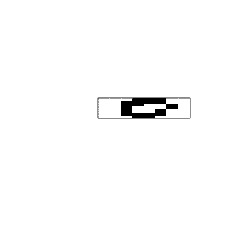

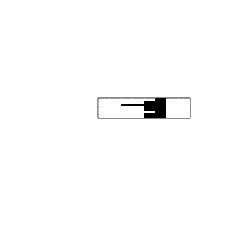

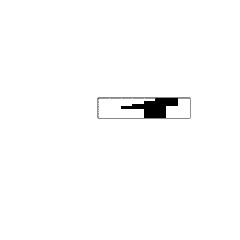

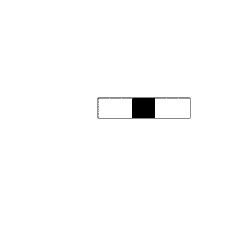

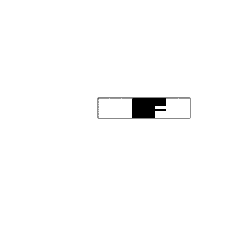

[1] 2


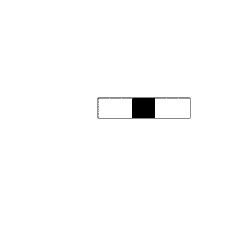

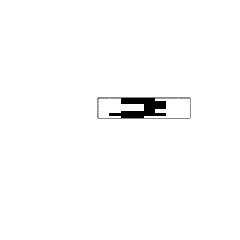

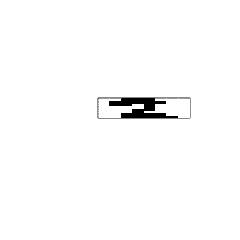

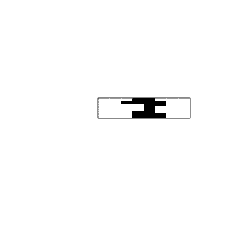

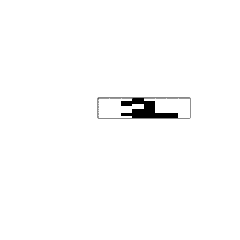

[1] 3


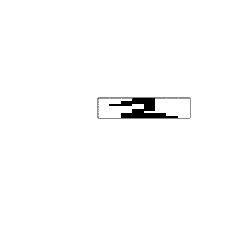

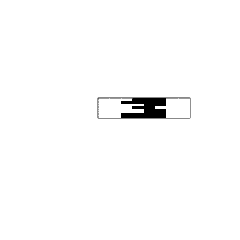

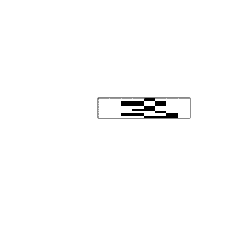

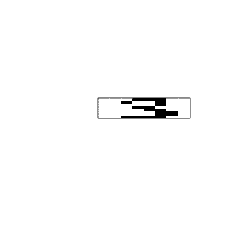

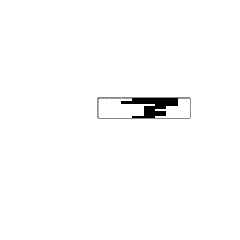

[1] 4


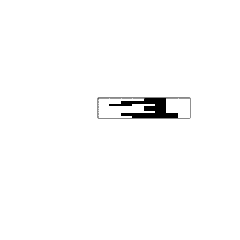

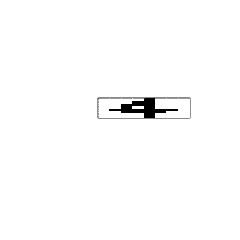

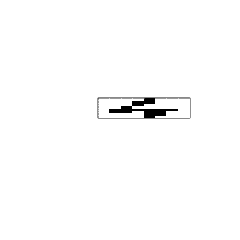

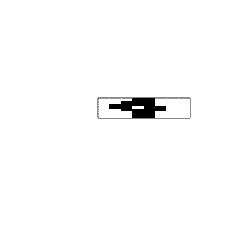

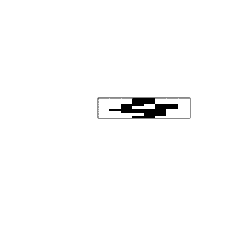

[1] 5


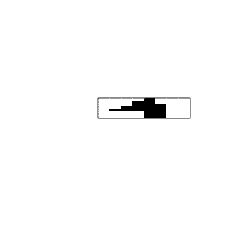

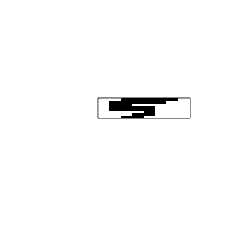

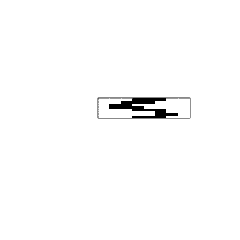

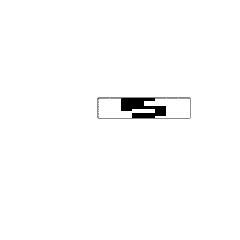

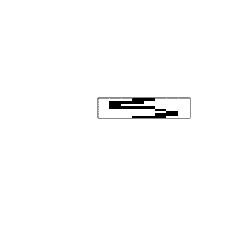

[1] 6


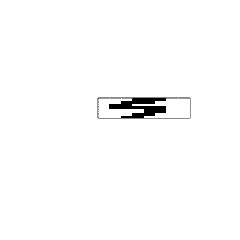

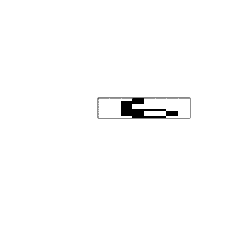

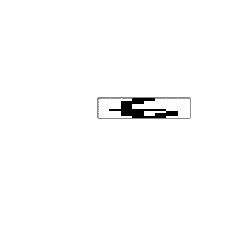

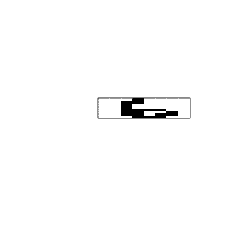

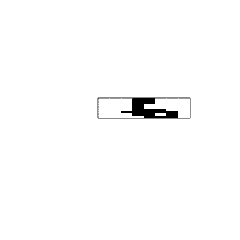

[1] 7


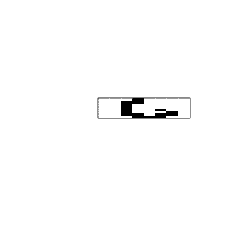

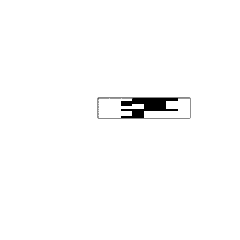

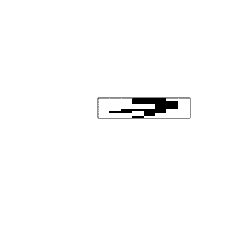

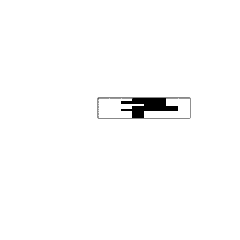

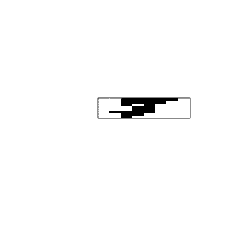

[1] 8


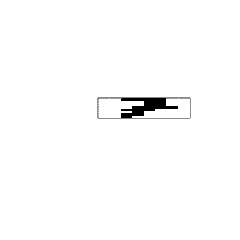

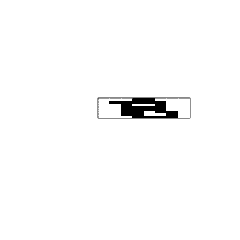

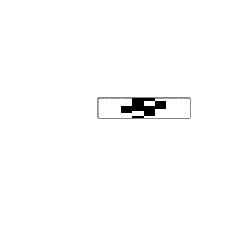

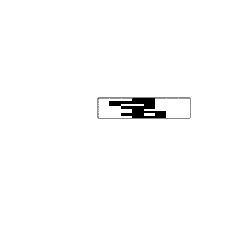

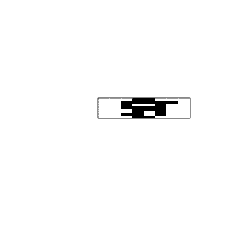

[1] 9


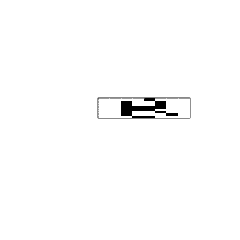

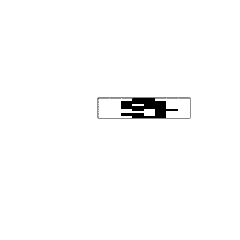

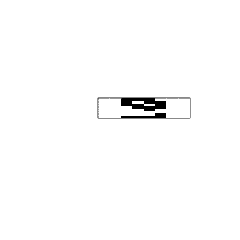

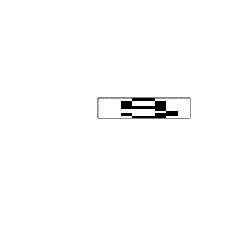

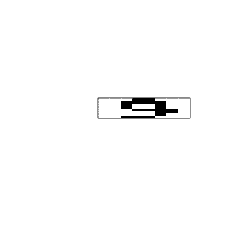

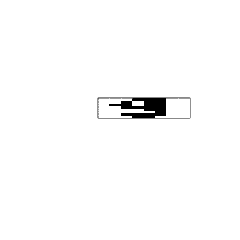

In [110]:
options(repr.plot.width=2, repr.plot.height=2)

q = 5
for (i in 1:k)
{
    I = which(y==CL[i])
    print(CL[i])
    for (j in 1:q)
    {
        
        f = as.numeric(X[I[j],])
        f = f / max(f)
        dim(f) = c(sqrt(p), sqrt(p))
        image(-f[,ncol(f):1], col=gray(c(0,1)), xaxt="n", yaxt="n")
    }
}

Display in 2D.

In [177]:
Xm = function(X){as.matrix(X - rep(colMeans(X), rep.int(nrow(X), ncol(X))))}
plot_multiclasses = function(X, Y, dim)
{
    
    svd_decomp = svd(Xm(X))
    U = svd_decomp$u
    D = svd_decomp$d
    V = svd_decomp$v
    Z = Xm(X) %*% V
    classes = sort(unique(y))
    nb_classes = length(classes)

    if (dim == 2)
    {
        for (i in classes)
        {
            I = (y==i)
            plot(Z[I,1], Z[I,2], col=i + 1, xlim=c(min(Z[,1]), max(Z[,1])),  
                 ylim=c(min(Z[,2]), max(Z[,2])), xlab="", ylab="", pch=16)
            par(new=TRUE)
        }

    cols = c(2:(nb_classes + 1))
    legend("topright", legend=classes, col=cols, pch="o")
    }
    else if(dim == 3)
    {
        first = TRUE
        for (i in classes)
        {
            I = (y==i)
            if (first==TRUE)
            {
                scatter3D(Z[I,1], Z[I,2], Z[I,3], col=i + 1, xlim=c(min(Z[,1]), max(Z[,1])),  
                          ylim=c(min(Z[,2]), max(Z[,2])), zlim=c(min(Z[,3]), max(Z[,3])), xlab="", ylab="",
                          zlab="", pch=16)
                first = FALSE
                par(new=TRUE)
                
            }
            else
            {
                 scatter3D(Z[I,1], Z[I,2], Z[I,3], col=i + 1, xlim=c(min(Z[,1]), max(Z[,1])),  
                           ylim=c(min(Z[,2]), max(Z[,2])), zlim=c(min(Z[,3]), max(Z[,3])), xlab="", ylab="",
                           zlab="", add=TRUE, pch=16)
            }
        }

        cols = c(2:(nb_classes + 1))
        legend("topright", legend=classes, col=cols, pch="o")
    }

}

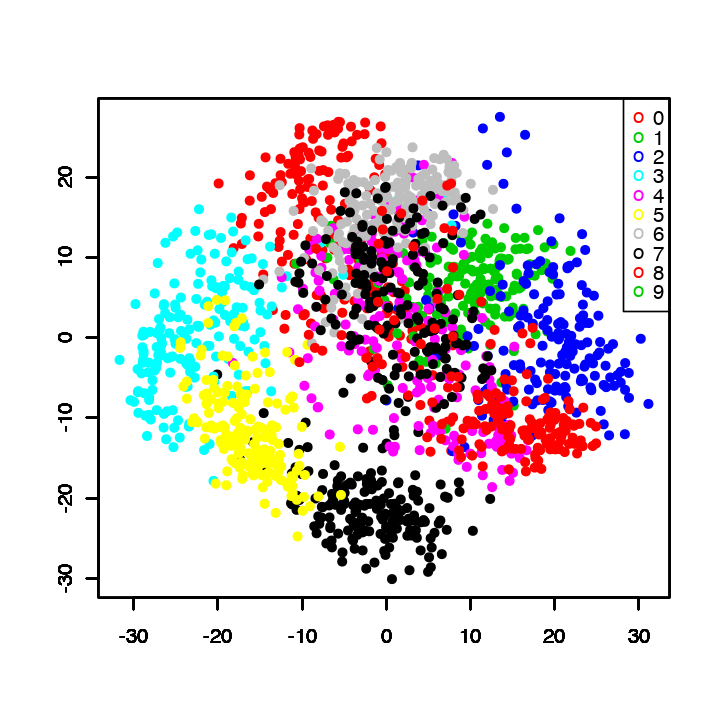

In [178]:
options(repr.plot.width=6, repr.plot.height=6)

plot_multiclasses(X, y, 2)

Display in 3D.

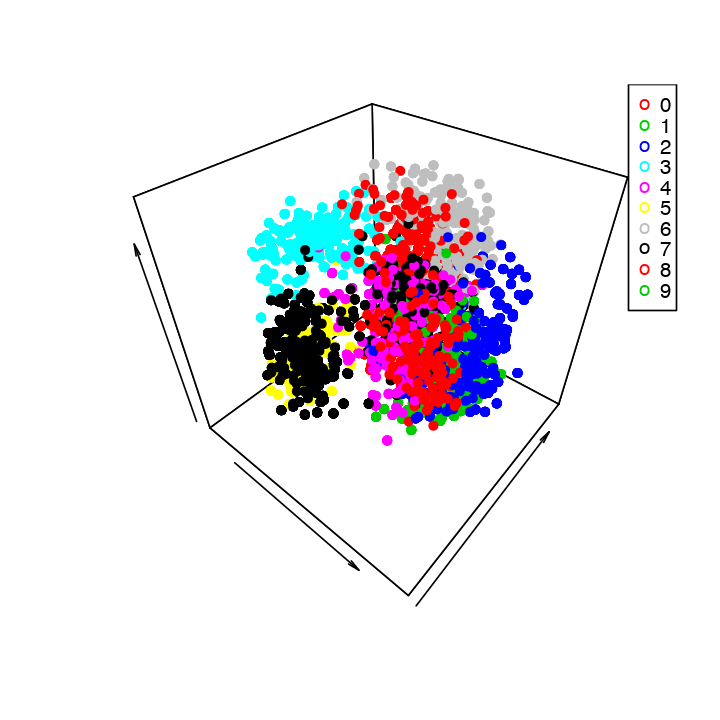

In [179]:
plot_multiclasses(X,y, 3)

Compute the $D$ matrix.

In [180]:
D = matrix(0, nrow=n, ncol=k)
for (i in 1:n)
{
    for (j in 1:k)
    {
        if (y[i] == (j - 1)){D[i, j] = 1}
    }
}

Define the energy $E(W)$.

In [181]:
E = function(W){(1./n) * (sum(LSE(X %*% W)) - (c(X %*% W) %*% c(D)))}

Define its gradients
  $$ \nabla E(W) =  \frac{1}{n} X^\top ( \text{SM}(X W) - D ).  $$

In [182]:
nablaE = function(W){1./n * t(X) %*% ( SM(X %*% W) -  D)}

__Exercise 7__

Implement a gradient descent
$$ W_{\ell+1} = W_\ell - \tau_\ell \nabla E(W_\ell). $$
Monitor the energy decay.

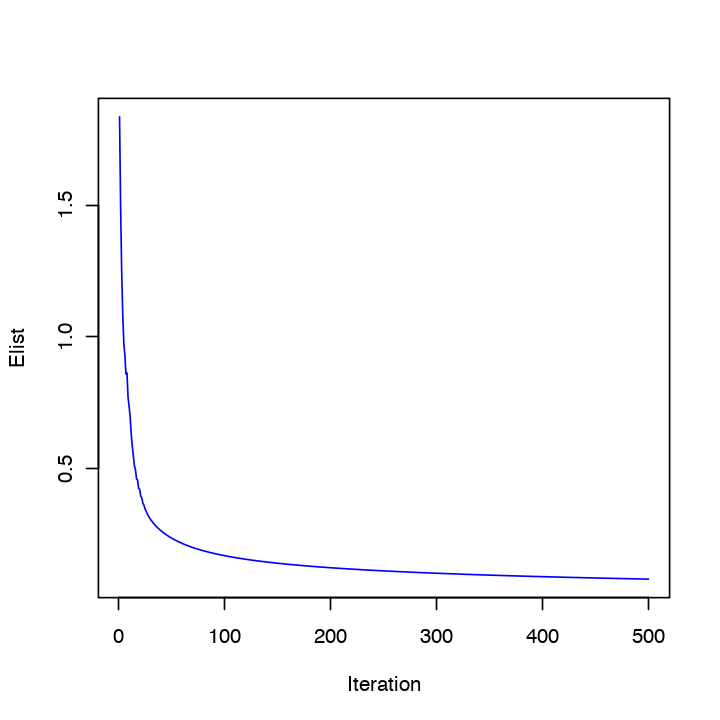

In [183]:
W = matrix(0, nrow=p, ncol=k)
Elist = c()
tau = 0.01
niter = 500
for (i in 1:niter)
{
    W = W - tau * nablaE(W)
    Elist = c(Elist, E(W))
}

plot(c(1: niter), Elist, type="l" ,col="blue", xlab="Iteration")

In [ ]:
exo7()

In [ ]:
%% Insert your code here.

Generate a 2D grid of points over PCA space and map it to feature space.

In [136]:
svd_decomp = svd(Xm(X))
U = svd_decomp$u
D = svd_decomp$d
V = svd_decomp$v
Z = Xm(X) %*% V
M = max(abs(c(Z)))
        
q = 201
t = seq(-M, M, length=q)
B = as.vector(meshgrid(t, t)$X)
A = as.vector(meshgrid(t, t)$Y)

G = matrix(0, nrow=q*q, ncol=p)
G[,1:2] = c(A, B)
G = G %*% t(V) + matrix(rep(apply(X, 2, mean), q*q), nrow=q*q, ncol=dim(X)[2])

Evaluate class probability associated to weight vectors on this grid.

In [139]:
Theta = SM(G %*% W)
dim(Theta) = c(q, q, k)

Display each probablity map.

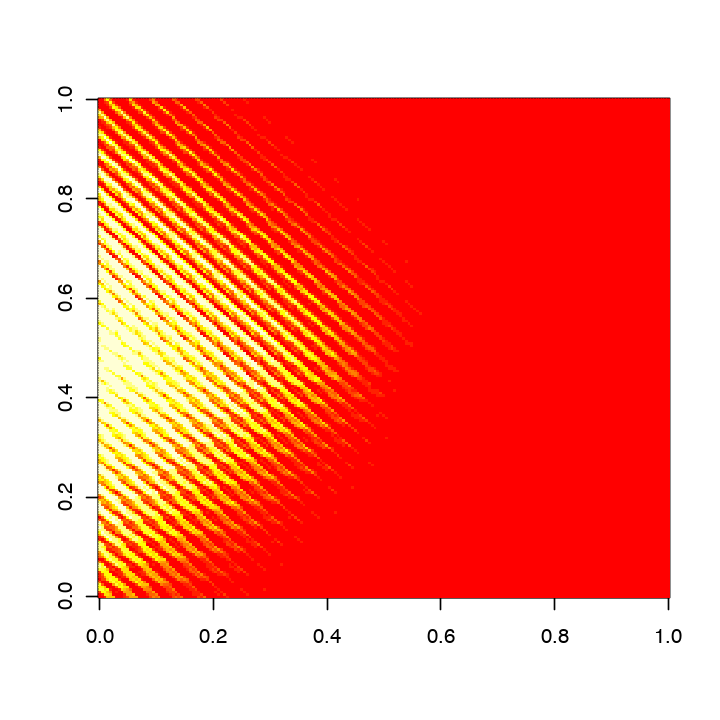

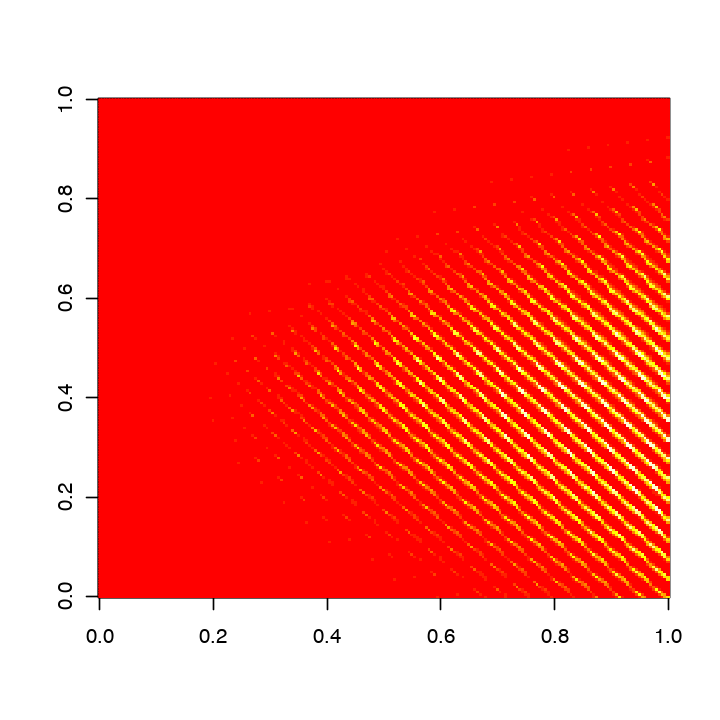

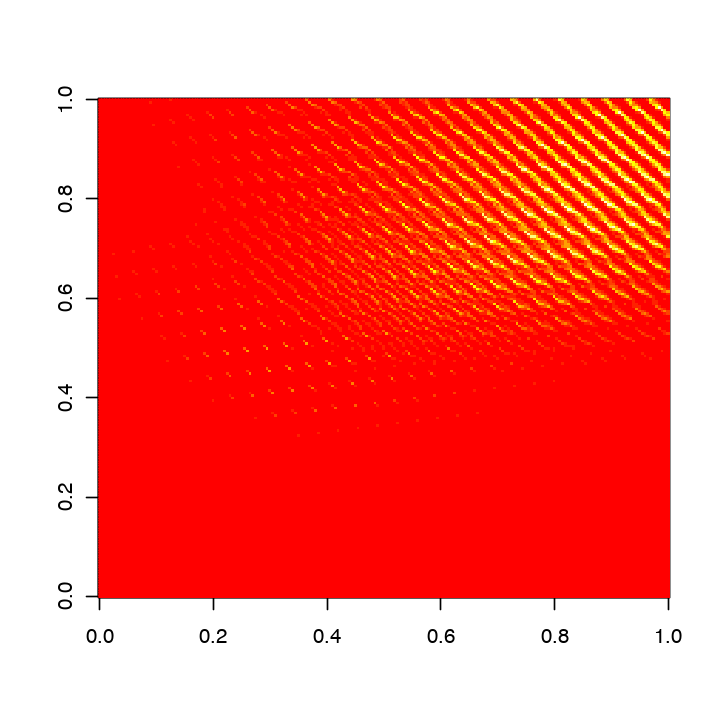

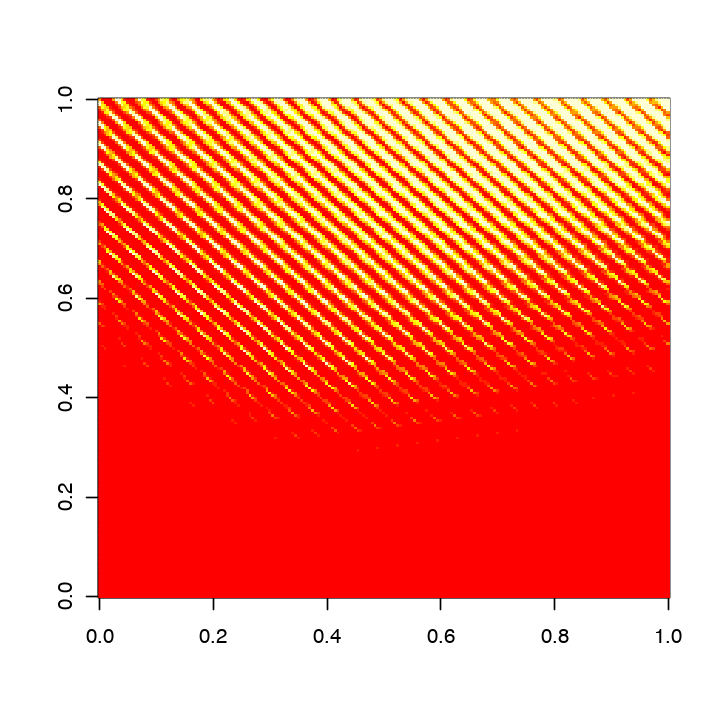

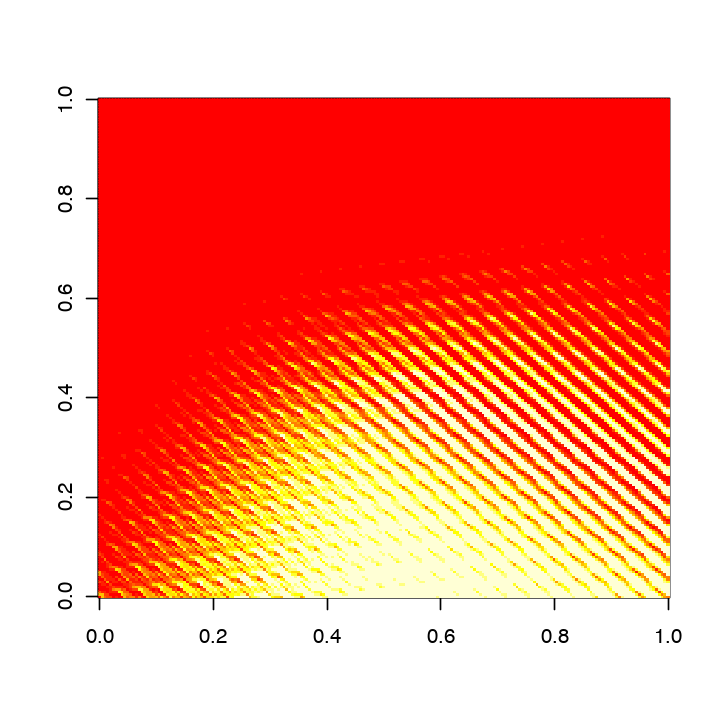

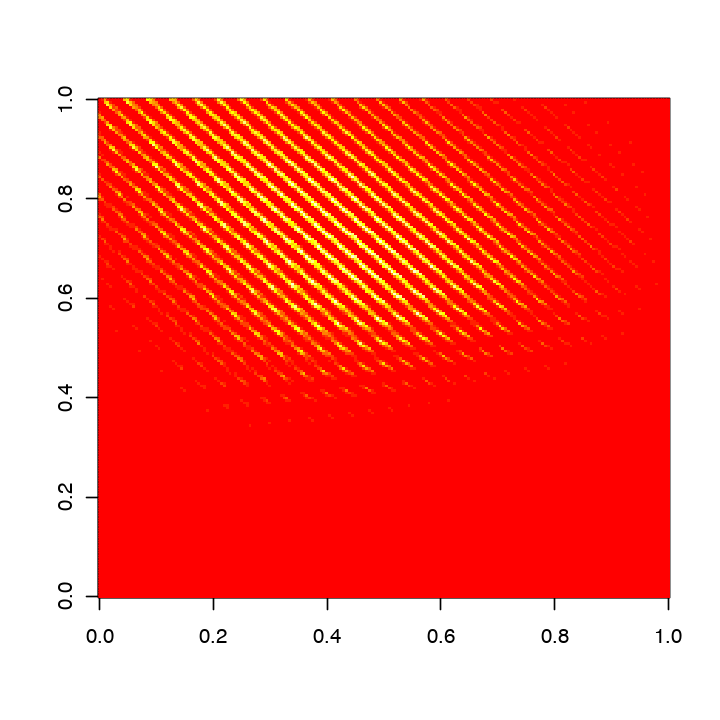

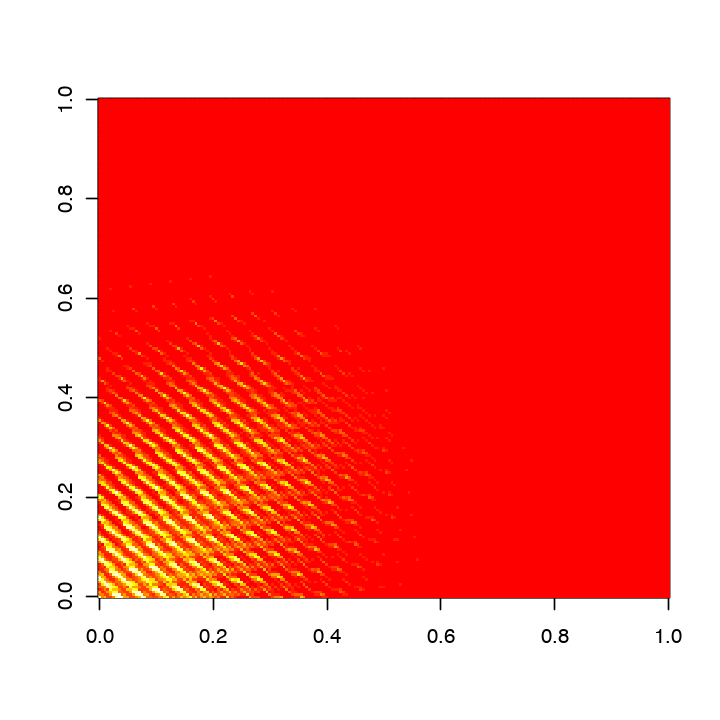

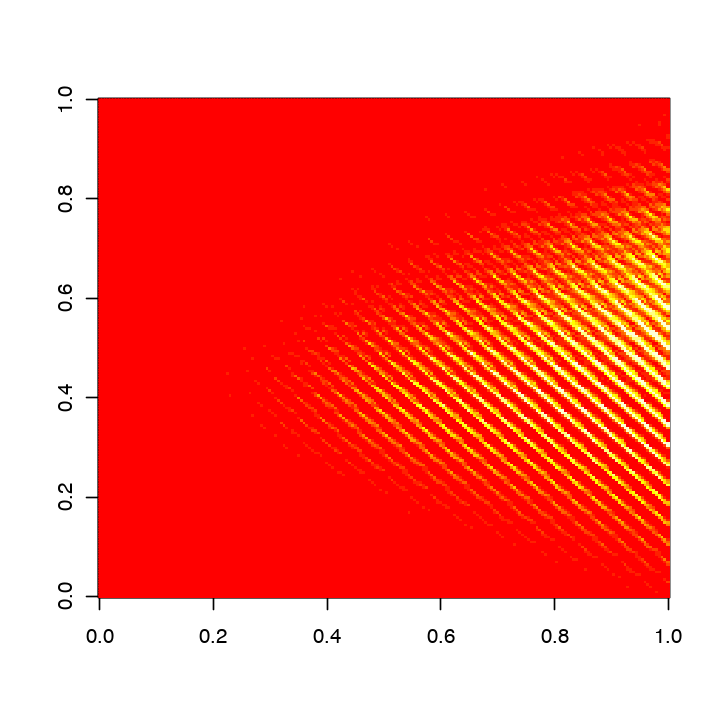

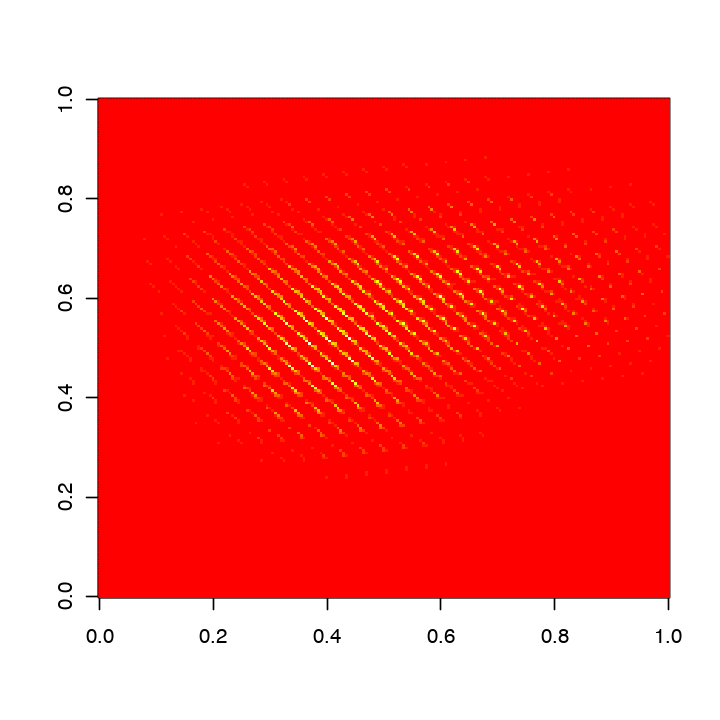

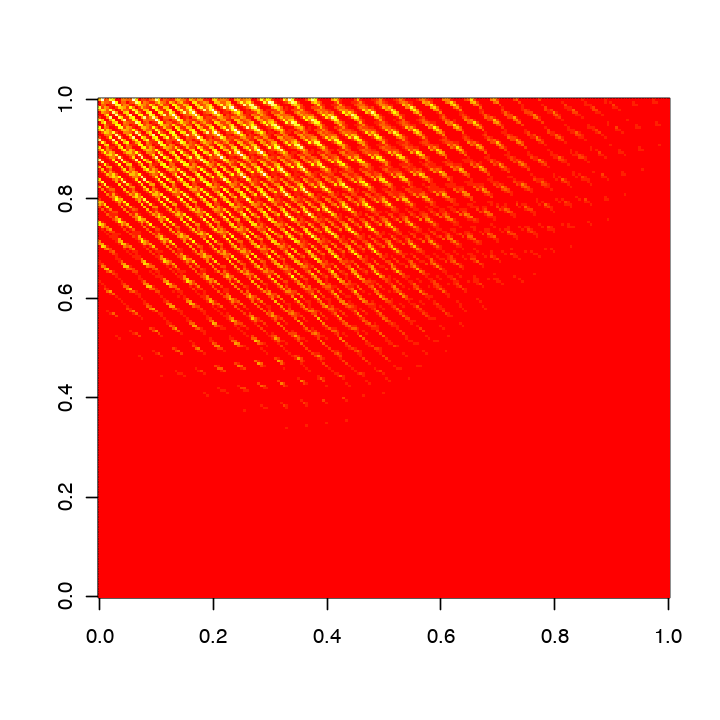

In [217]:
for (i in 1:k)
{
    image(t(Theta[,,i]))
}

Build a single color image of this map.

In [205]:
plot_multiclasses_bis = function(X, Y, dim)
{
    
    svd_decomp = svd(Xm(X))
    U = svd_decomp$u
    D = svd_decomp$d
    V = svd_decomp$v
    Z = Xm(X) %*% V
    classes = sort(unique(y))
    nb_classes = length(classes)

    for (i in classes)
    {
        I = (y==i)
        color = col[,i + 1]
        plot(Z[I,1], Z[I,2], col=rgb(color[1], color[2], color[3]), xlim=c(min(Z[,1]), max(Z[,1])),  
             ylim=c(min(Z[,2]), max(Z[,2])), xlab="", ylab="", pch=16)
        par(new=TRUE)
    }
}

In [211]:
res = 

In [184]:
col = c(1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, .5, .5, .5, 1, .5, .5, .5, 1)
col = matrix(col, nrow=3, ncol=k)

R = array(0, dim=c(q,q,3))
(1, 0, 2)

for (i in 1:k)
{
    for (a in 1:3)
    {
        R[,,a] = R[,,a] + Theta[,,i] * col[a,i]
    }
}

In [210]:
col

1,0,0,0,0,1,1,1.0,0.5,0.5
0,1,0,0,1,0,1,0.5,1.0,0.5
0,0,1,0,1,1,0,0.5,0.5,1.0


Display.

In [185]:
source("nt_toolbox/general.R")
source("nt_toolbox/signal.R")
source("nt_toolbox/perform_wavelet_transf.R")

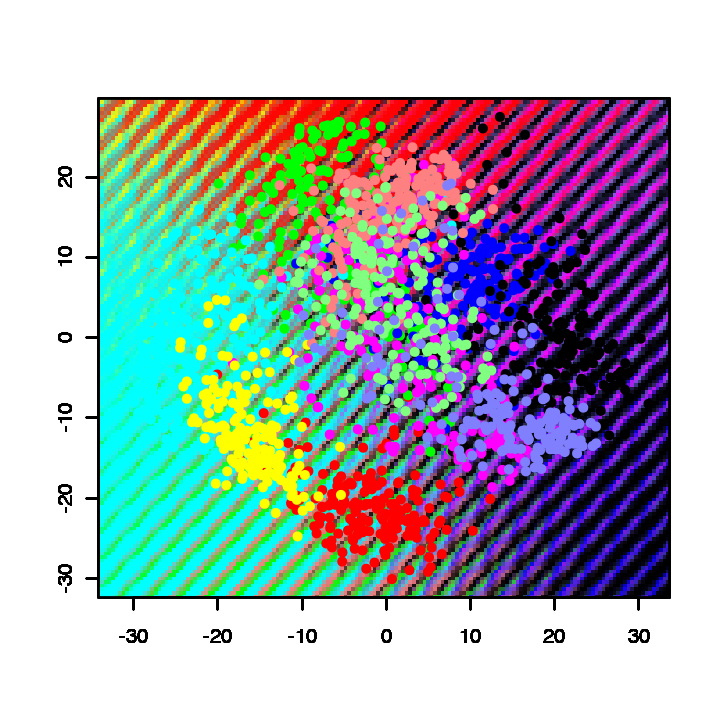

In [220]:
library(grid)
plot_multiclasses(X, y, 2)
par(new=TRUE)
grid.raster(aperm(R, c(2, 1, 3)), interpolate=FALSE)
plot_multiclasses_bis(X, y, 2)

__Exercise 8__

Separate the dataset into a training set and a testing set. Evaluate the classification performance
and display the confusion matrix. You can try the impact of kernlization and regularization.

In [ ]:
exo8()

In [ ]:
%% Insert your code here.